# Прогноз оттока клиентов телеком-компании

Телеком-компания столкнулась с оттоком клиентов. Привлечение новых или возвращение ушедших к конкурентам клиентов обходится компании дороже, чем удержание "сомневающихся". Компания хочет научиться прогнозировать желание клиентов уйти, чтобы вовремя предложить им промокоды и специальные условия.

# Цель проекта

Необходимо построить модель, решающую задачу классификации и предсказывающую намерение клиента уйти из компании. Заказчик требует, чтобы метрика качества AUC-ROC были выше 0.75 (желательно - выше 0.85).

# Содержание <a name="contents"></a>
1. [Пран работы](#introduction)
2. [Импорт библиотек](#paragraph1)
3. [Закомство с данными и предобработка](#paragraph2)
    1. [Информация о контрактах](#subparagraph2.1)
    2. [Персональные данные клиентов](#subparagraph2.2)
    3. [Интернет-услуги](#subparagraph2.3)
    4. [Телефония](#subparagraph2.4)
    5. [Выводы по разделу](#subparagraph2.5)
4. [Исследовательский анализ данных](#paragraph3)
    1. [Исследование расходов клиентов](#subparagraph3.1)
    2. [Поиск сомнительных записей](#subparagraph3.2)
    3. [Генерация искусственных признаков](#subparagraph3.3)
    4. [Выводы по разделу](#subparagraph3.4)
5. [Подготовка данных](#paragraph4)
    1. [Подготовка выборок](#subparagraph4.1)
    2. [Кодирование признаков](#subparagraph4.2)
6. [Построение модели](#paragraph5)
    1. [Обучение и сравнение моделей](#subparagraph5.1)
    2. [Улучшение модели-лидера](#subparagraph5.2)
    3. [Тестирование модели](#subparagraph5.3)
7. [Общий вывод](#paragraph6)
8. [Отчет о результатах работы](#paragraph7)

# План работы <a name="introduction"></a>
1. Знакомство с данными и предобработка - посмотрим, какие данные имеются в нашем распоряжении. Если в данных окажутся дубликаты, пропуски (явные и неявные), аномалии или артефакты, то попробуем их исправить (или удалить).


2. EDA - исследуем данные и определим какие из них и в каком виде будут переданы в модель. Найдем и исключим потенциально недостоверные данные, если их доля в датасете незначительна. Проведем feature engineering, чтобы создать полезные синтетические признаки на основе данные, которые нельзя и (или) нецелесообразно передаветь в модель напрямую.


3. Построение модели - подготовим данные для передачи в модель (закодируем/отмасштабируем признаки), сформируем выборки и обучим несколько моделей (логистическую регрессию, случайный лес и модель, работающую по алгоритму градиентного бустинга). Сравним качество предсказаний (метрика качества - AUC-ROC), баланс ошибок первого и второго рода и выберим лучшую модель. Для управления псевдо-случайность используем параметр random_state = 250722. Для улучшения качества предсказаний модели используем балансировку классов.


4. Подготовка отчета - сформулируем выводы и оценим результаты работы.

***

[Вернуться к содержанию](#contents)

## Импорт библиотек <a name="paragraph1"></a>

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# импорт библиотеки для проведения теста по критерию хи-квадрат
from scipy.stats import chi2_contingency
from phik.report import plot_correlation_matrix

# импорт библиотеки для подсчета времени исполнения кода
import time

# импорт библиотеки для работы со временем
import datetime

import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

# импорт библиотеки для ресемплирования данных
from imblearn.over_sampling import SMOTE 

# импорт построение, обучени и оценки моделей
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_curve, confusion_matrix

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

print('Библиотеки загружены успешно.')

Библиотеки загружены успешно.


## Знакомство с данными и предобработка  <a name="paragraph2"></a>

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — сведения о контрактах;
- `personal.csv` — персональные данные клиентов;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Загрузим таблицы и познакомимся с данными.

In [2]:
contract = pd.read_csv('contract.csv')
personal = pd.read_csv('personal.csv')
internet = pd.read_csv('internet.csv')
phone = pd.read_csv('phone.csv')

### Информация о контрактах <a name="subparagraph2.1"></a>

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Информация о договоре содержит 8 колонок:
- `customerID` — уникальный номер клиента;
- `BeginDate` — дата заключения договора;
- `EndDate` — дата закрытия договора;
- `Type` — тип контракта (с ежемесячной оплатой или на 1-2 года);
- `PaperlessBilling` — метка безналичного расчета;
- `PaymentMethod` — форма выставления счета;
- `MonthlyCharges` — среднемесячные расходы клиента;
- `TotalCharges` — накопленная выручка компании с каждого клиента на 1 февраля 2020 года или на дату расторжения договора.


Посмотрим подробнее на содержание отдельных колонок.

In [4]:
print('Количество дубликатов в идентификаторах пользователей:', contract.duplicated(subset='customerID').sum())
print('Типы контрактов по длительности:', list(contract['Type'].unique()))
print('Типы контрактов по форме выставления счете:', list(contract['PaymentMethod'].unique()))
print('Типы меток безналичной оплаты:', list(contract['PaperlessBilling'].unique()))

Количество дубликатов в идентификаторах пользователей: 0
Типы контрактов по длительности: ['Month-to-month', 'One year', 'Two year']
Типы контрактов по форме выставления счете: ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Типы меток безналичной оплаты: ['Yes', 'No']


**Наблюдения**

В нашем распоряжении записи о 7043 договорах. Идентификаторы клиентов не повторяются (один клиент - один договор). Договора бывают как с ежемесячной оплатой, так и заключенные на срок 1 или 2 года. Оплата может списываться со карты клиента автоматические или путем направления клиенту счета (бумажного или электронного).






Колонка **EndDate** содержит сведения о дате расторжения договора, преобразовав которые мы получим значения целевого признака - закрыт договор (1) или нет (0). Запишем классы наших объектов в новую колонку **target**.

In [5]:
# создадим колонку с целевым признаком
contract.loc[contract['EndDate'] == 'No', 'target'] = 0
contract.loc[contract['EndDate'] != 'No', 'target'] = 1
contract['target'] = contract['target'].astype('int8')
contract[['EndDate', 'target']].head()

,EndDate,target
0,No,0
1,No,0
2,2019-12-01 00:00:00,1
3,No,0
4,2019-11-01 00:00:00,1


Теперь данные о дате регистрации договора **BeginDate** и о дате расторжения **EndDate** нужно превести к типу `datetime` - они могут пригодится для создания синтетических признаков.

In [6]:
# преобразуем данные в столбцам BeginDate, EndDate в тип datetime 
# там, где это не получится сделать, проставим NaT, которые будет легко отследить
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d', errors='coerce')
contract['BeginDate']= pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

С данными о накопленной выручке в колонке **TotalCharges** проблема. Среди численных значений где-то спрятались артефакты - найдем их.

In [7]:
# в новый столбец TotalCharges_fixed запишем преобразованные в числа 
# значения накопленной выручки с каждого клиента
# там, где это не получится сделать, проставим NaN, которые будет легко отследить
contract['TotalCharges_fixed'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
# посмотрим на записи с некорректными заначениями
contract[contract['TotalCharges_fixed'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,TotalCharges_fixed
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,,0,NaN
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,,0,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,,0,NaN
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,,0,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,,0,NaN
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,,0,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,,0,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,,0,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,,0,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,,0,NaN


Проблема с типом данных в колонке **TotalCharges** в пустых строках у клиентов, заключивших договор в день выгрузки данных 1 февраля 2020. Статистика по накопленной выручке по ним не успела накопиться. Избавимся от этих записей.

In [8]:
# удаляем записи с пропусками в колонке TotalCharges_fixed и обновляем индексы
contract.dropna(subset=['TotalCharges_fixed'], inplace=True)
contract.reset_index(inplace=True, drop=True)
# переписываем содержимое колонки TotalCharges
contract['TotalCharges'] = contract['TotalCharges_fixed']
# удаляем временную колонку TotalCharges_fixed 
contract.drop('TotalCharges_fixed', axis=1, inplace=True)

Данные о контрактах загружены, cформирована колонка с целевым признаком.

***

[Вернуться к содержанию](#contents)

### Персональные данные клиентов  <a name="subparagraph2.2"></a>

In [9]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Информация о клиенте содержит 5 колонок:
- `customerID` — уникальный номер клиента;
- `gender` — пол клиента;
- `SeniorCitizen` — метка возрастной категории клиента (пенсионер или нет);
- `Partner` — метка семейного статуса (есть партнер или нет);
- `Dependents` — факт наличия у клиента иждивенцев.

Проверим данные в колонках на предмет аномальных значений.

In [10]:
print('Количество дубликатов в идентификаторах пользователей:', personal.duplicated(subset='customerID').sum())
print('Типы меток возрастной категории клиента:', list(personal['SeniorCitizen'].unique()))
print('Типы меток семейного статуса клиента:', list(personal['Partner'].unique()))
print('Типы меток наличия иждивенцев у клиента:', list(personal['Dependents'].unique()))

Количество дубликатов в идентификаторах пользователей: 0
Типы меток возрастной категории клиента: [0, 1]
Типы меток семейного статуса клиента: ['Yes', 'No']
Типы меток наличия иждивенцев у клиента: ['No', 'Yes']


**Наблюдения**

Персональные данные клиентов загружены корректно и содержат 7042 записи с 4 характеристиками. Пропусков и аномалий нет.

***

[Вернуться к содержанию](#contents)

### Интернет-услуги  <a name="subparagraph2.3"></a>

In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Информация о подключенных интернет-услугах содержит 8 колонок:
- `customerID` — уникальный номер клиента;
- `InternetService` — тип подключения (телефонная линия или оптика);
- `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies` — метки использования клиентом дополнительных услуг.

In [12]:
print('Количество дубликатов в идентификаторах пользователей:', internet.duplicated(subset='customerID').sum())
print(f'Доля клиентов клентов компании, пользующихся интернетом: {len(internet) / len(contract):.0%}')

Количество дубликатов в идентификаторах пользователей: 0
Доля клиентов клентов компании, пользующихся интернетом: 78%


**Наблюдения**

Данные о потребленных клиентами интернет-услугах загружены и содержат 5517 записей. Пропусков и аномалий нет.

***

[Вернуться к содержанию](#contents)

### Телефония  <a name="subparagraph2.4"></a>

In [13]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Информация об услугах телефонии содержит 2 колонки:
- `customerID` — уникальный номер клиента;
- `MultiplieLines` —  метка использования клиентом дополнительной услуги.

In [14]:
print('Количество дубликатов в идентификаторах пользователей:', phone.duplicated(subset='customerID').sum())
print(f'Доля клиентов клентов компании, пользующихся стационарным телефоном: {len(phone) / len(contract):.0%}')

Количество дубликатов в идентификаторах пользователей: 0
Доля клиентов клентов компании, пользующихся стационарным телефоном: 90%


**Наблюдения**

Данные о потребленных клиентами услугах телефонии загружены и содержат 6361 запись. Пропусков и аномалий нет.

***

[Вернуться к содержанию](#contents)

### Выводы по разделу <a name="subparagraph2.5"></a>

Исходные данные загружены и предобработаны:
 - календарные данные о датах открытия и закрытия договоров приведены к типу `datetime` там, где это возможно;
 - единичные записи с пропусками в колонке с суммарной выручкой по клиенту удалены;
 - данные проверены на предмет дубликатов и артефактов;
 - в таблице **contract** сформирована колонка **target** с целевым признаком.
 
При знакомстве с данными мы выяснили, что 90% клиентов пользуются стационарной телефонной связью и только 78% пользуются интернетом. Почти все категориальные признаки в таблицах бинарные - это значит, что при построении модели мы сможем использовать простое и эффектвное прямое кодирование и размерность матрицы признаков не будет чрезмерной.

***

[Вернуться к содержанию](#contents)

## Исследовательский анализ данных <a name="paragraph3"></a>

В нашем случае задача исседовательного анализа - определить, какие признаки в каком виде будут переданы в модель. Познакомившись с данными, договоримся, что персональные данные клиентов и информация об интересующих их услугах будет использована в качестве признаков в полном объеме (после соответсвующей подготовки) и сосредоточимся на исследовании данных о заключенных и расторгнутых договорах. 

In [15]:
print('Баланс классов в исходных данных:\n')
contract['target'].value_counts(normalize=1)

Баланс классов в исходных данных:



0    0.734215
1    0.265785
Name: target, dtype: float64

Классы несбалансированны - это нужно будет учесть.

### Расходы клиентов <a name="subparagraph3.1"></a>

Исследуем главную доступную нам количественную характеристику клиентов - среднемесячную выручку по клиентам в колонке **MonthlyCharges**. Разделим клиентов на лояльных и покинувших компанию и оценим размах и распределение среднемеческой выручки. Так мы оценим достовернось данных и проверим очевидную догадку - "Клиенты уходят потому, что дорого". Может быть компании нужно просто снизить цену на свои услуги до уровня конкурентов?

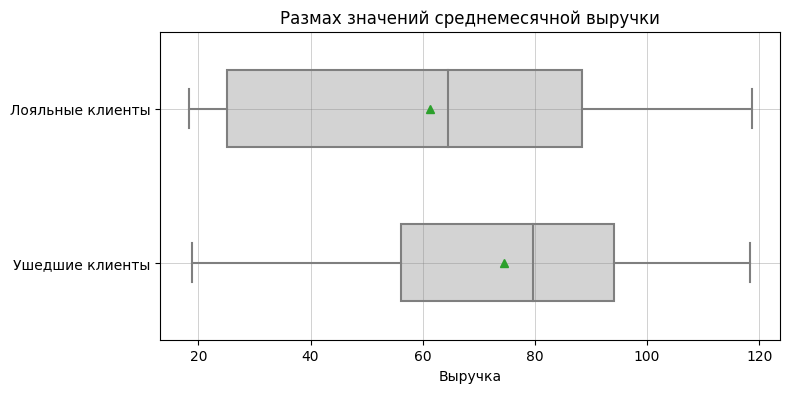

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.boxplot(data=contract, y='target', x='MonthlyCharges', 
            width=0.5, color='lightgray', showmeans=True, showfliers=True, ax=ax, orient='h')
ax.grid(color='gray', alpha=0.5, lw=0.5)
plt.xlabel('Выручка')
plt.ylabel('')
plt.yticks([0, 1], ['Лояльные клиенты', 'Ушедшие клиенты'])
plt.title('Размах значений среднемесячной выручки');

Аномальных значений нет. Верхние и нижние границы значений выручки совпадают, но среднемесячные расходы ушедших клиентов в среднем выше, чем у лояльных клиентов. Расходы половины ушедших клиентов превышали средние расходы лояльных клиентов. Эта часть клиентов покинула компанию потому, что их расходы превысили ожидания, - это логично и ожидаемо. 

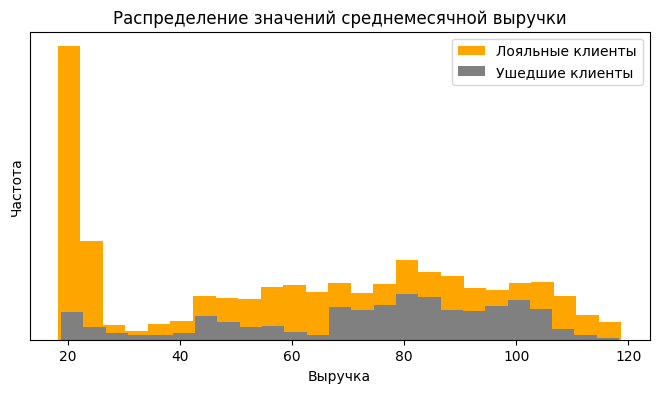

In [17]:
plt.subplots(figsize=(8, 4))
plt.hist(contract[contract['target'] == 0]['MonthlyCharges'], label='Лояльные клиенты', bins=25, density=False, color='orange')
plt.hist(contract[contract['target'] == 1]['MonthlyCharges'], label='Ушедшие клиенты', bins=25, density=False, color='gray')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.yticks([])

plt.legend()
plt.title('Распределение значений среднемесячной выручки');

Распределения похожи, но на гистограмме расходов лояльных выделяется "пик" тех, кто сидит на минимальном месячном платеже, - таких клиентов все устраивает.

**Наблюдения**

Данные о среднемесячной выручке лояльных и ушедших клиентов будем считать достоверными. Сравнительно высокими расходами можно объяснить уход только части клиентов, остальные клиенты покинули компанию по менее очевидным причинам.  

***

[Вернуться к содержанию](#contents)

### Поиск сомнительных записей <a name="subparagraph3.2"></a>
Посмотрим на временные рамки имеющихся в нашем распоряжении данных.

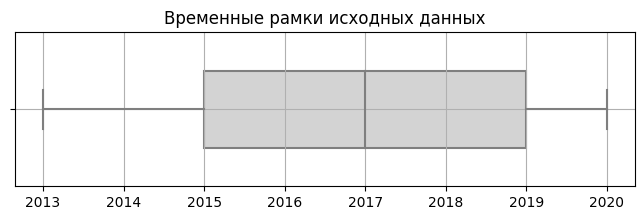


Самое частотное значение: 2019


In [18]:
plt.subplots(figsize=(8, 2))
sns.boxplot(x=pd.DatetimeIndex(contract['BeginDate']).year,
            width=0.5, color='lightgray', showmeans=False, showfliers=True, orient='h')
plt.title('Временные рамки исходных данных')
plt.grid(True)
plt.xlabel('')
plt.show()
print('\nСамое частотное значение:', 
      max(set(list(pd.DatetimeIndex(contract['BeginDate']).year)), 
          key=list(pd.DatetimeIndex(contract['BeginDate']).year).count));

В нашем распоряжении данные о договорах, открытых с 2013 по 2020 год.

Предположим, что условия договора, заключенного на 1 или 2 года, предусматривают штрафные санкции в случае его досрочного расторжения по инициативе клиента. Так, например, в США за символическую цену продают айфоны, к которым прилается обязательный годовой контракт с сотовым оператором, дострочное расторжение которого грозит выплатой неустойки, равной полной стоимости айфона.

Следуя этой логике, предположим, что клиент, заключивший срочный контракт с телеком-компанией получил за это какие-то скидки, бонусы или "бесплатный" роутер и не будет досрочно расторгать договор, даже желая уйти к другому оператору, из-за не желания платить неустойку. В таком случае "лояльность" подобного клиента будет потенциально недостоверной.

Найдем таких клиентов, учитывая дата выгрузки данных - 1 февраля 2020 года.

In [19]:
unreliable_contracts = contract[
         # клиенты заключившие договор с ежемесячной платой менее, чем за месяц до даты выгрузки
         # по ним не накопилось никакой адекватной статистики
         ((contract['BeginDate'] > '2020-01-01') & (contract['Type'] == 'Month-to-month'))
         |
         # клиенты заключившие договор сроком на 1 год менее, чем за год до даты выгрузки
         ((contract['BeginDate'] > '2019-02-01') & (contract['Type'] == 'One year'))
         |
         # клиенты заключившие договор сроком на 2 год менее, чем за два года до даты выгрузки
         ((contract['BeginDate'] > '2018-02-01') & (contract['Type'] == 'Two year'))
         ]
print('Количество потенциально недостоверных записей:', len(unreliable_contracts))         

Количество потенциально недостоверных записей: 230



С помощью аналитического метода Хи-квадрат проверим нулевую гипотезу, что статус клиента-новичка никак не влияет на факт расторжения договора.

In [20]:
# создадим колонку new, чтобы отметить клиентов-новичков
unreliable_contracts['new'] = 1
contract = contract.merge(unreliable_contracts[['customerID','new']], how='left')
contract['new'] = contract['new'].fillna(0)

In [21]:
# из данных в колонка new и traget созданим кросс-таблицу chisqt,
# которая отображает частотное распределение признаков new и target
chisqt = pd.crosstab(contract['new'], contract['target'], margins=True)
# применим к заниченим таблицы тест хи-квадрат и проверим нулевую гипотезу
value = np.array([chisqt.iloc[0][0:4].values,
                  chisqt.iloc[1][0:4].values])
print('p-value = ', chi2_contingency(value)[1])
if chi2_contingency(value)[1] > 0.05:
    print('Принимаем нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

p-value =  1.7440070803124201e-16
Отвергаем нулевую гипотезу


In [22]:
contract.drop(['new'], axis=1, inplace=True)

Нулевая гипотеза отвергнута - статус новичка влияет на решение клиента остаться или покинуть компанию. Удалим 230 записей о клиентах с потенциально неверной оценкой лояльности и в исходных данных останутся только однозначно лояльные и ушедшие клиенты.

In [23]:
# исключим из основной таблицы contract клиентов из таблицы unreliable_contracts
contract = contract[~(contract['customerID'].isin(unreliable_contracts['customerID']))]

In [24]:
print('Количество записей о договорах после очистки:', len(contract))

Количество записей о договорах после очистки: 6802


Мы избавились от записей о клиентах, лояльность которых сомнительна.

***

[Вернуться к содержанию](#contents)

### Генерация искусственных признаков <a name="subparagraph3.3"></a>
Какую полезную информацию мы можем извлечь из данных о дате заключения контракта и дате его расторжения? Передавать в модель даты заключения договоров - нельзя, но можно накапливать данные об общей продолжительности отношений клиента и компании и фактах того, что клиент не ушел после истечения первоначального срочного договора (месяц, год или два года).

Для каждого клиента мы создадим синтетические количественные признаки, которые будет характеризовать степень лояльности клиента (как активного, так и покинувшего компанию):
- **prolongation** - количество пролонгаций первоначального контракта на момент выгрузки данных;
- **duration** - "стаж" клиента в компании на момент выгрузки данных или на момент расторжения договора (в днях).

In [25]:
# заполним пропуски в дате расторжения контракта датой выгрузки
contract['EndDate'].fillna(
    pd.to_datetime('2020-02-01', format='%Y-%m-%d'),
    inplace=True)

# для каждого типа контракта вычислим целое число пролонгаций и запишем его в колонку prolongation
contract.loc[contract['Type'] == 'Month-to-month', 'prolongation'] = (contract['EndDate'] - contract['BeginDate']).dt.days // 30
contract.loc[contract['Type'] == 'One year', 'prolongation'] = (contract['EndDate'] - contract['BeginDate']).dt.days // 365
contract.loc[contract['Type'] == 'Two year', 'prolongation'] = (contract['EndDate'] - contract['BeginDate']).dt.days // 730

# для каждого клиента расчитаем "стаж"
contract['duration'] = (contract['EndDate'] - contract['BeginDate']).dt.days

contract['prolongation'] = contract['prolongation'].astype('int16')
contract['duration'] = contract['duration'].astype('int16')

Как мы условились ранее, в качестве признаков объектов мы используем все доступные личные данные клиентов и сведения об интересующих их услугах. 

Однако, некоторые данные лишние и не должны быть переданы в модель:
 - даты заключения и расторжения договора - из них мы сформировали синтетический признак prolongation);
 - суммарная выручка c каждого клиента - эти данные (в отличие от среднемесячной выручки) адекватно характеризуют только клиентов, растрогнувших договор, и оценивать по ним лояльных клиентов без учета изменений во времени некорректно.

Соберем все признаки в одну таблицу **clients**.

In [26]:
clients = contract.merge(personal, how='left')
clients = clients.merge(internet, how='left')
clients = clients.merge(phone, how='left')
clients.drop(labels=['BeginDate', 'EndDate', 'TotalCharges', 'customerID'], axis=1, inplace=True)
print('Количество пропущенных значений')
clients.isna().sum()

Количество пропущенных значений


Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
target                 0
prolongation           0
duration               0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1358
OnlineSecurity      1358
OnlineBackup        1358
DeviceProtection    1358
TechSupport         1358
StreamingTV         1358
StreamingMovies     1358
MultipleLines        651
dtype: int64

Т.к. интернетом пользуются 78% клиентов, а телефонией - 90%, при объедении таблиц в колонках с подключенными услугами возникли пропуски - заполним их значениями "No", чтобы сохранить бинарность признака (там, где это возможно). Для того, чтобы сохранить информацию об фактах подключения абонентов к интернету и телефонной линии, введем 2 новых признака **internet_usage**  и **phone_usage**.

In [27]:
# там, где есть пропуски в колонках MultipleLines и InternetService, запишем 0 в колонки phone_usage и internet_usage
clients.loc[clients['MultipleLines'].isna(), 'phone_usage'] = 0.
clients.loc[clients['InternetService'].isna(), 'internet_usage'] = 0.
# там, где пропусков нет - запишем 1
clients.loc[~(clients['MultipleLines'].isna()), 'phone_usage'] = 1.
clients.loc[~(clients['InternetService'].isna()), 'internet_usage'] = 1.

In [28]:
# заполним пропуски в колонках из списка labels заглушками No
labels = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for label in labels:
    clients[label].fillna('No', inplace=True)  

### Выводы по разделу <a name="subparagraph3.4"></a>

Задача данного исследовательского анализа выполнена выполенена - мы изучили данные, определили, какие из них должны быть переданы в модель, и изъяли полезную информацию из тех данных, которые не могут быть использованы напрямую. В результате мы получили обезличенную таблицу **clients**, которая содержит 6802 объектов с 21 признаком.

***

[Вернуться к содержанию](#contents)

## Подготовка данных <a name="paragraph4"></a>

### Подготовка выборок <a name="subparagraph4.1"></a>
Разделим данные на обучающую и тестовую выборку. Для теста отберем 20% данных.

In [29]:
target = clients['target']
features = clients.drop(['target'] , axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=250722)

### Кодирование признаков  <a name="subparagraph4.2"></a>

Для кодирования номинальных признаков при сравнительно малом разнообразии значений используем **One-Hot Encoding**. Простой и понятный метод, не создающий ложных зависимостей между закодированными значениями признаков. Применим этот метод к колонкам категориальным колонкам, данные к которых имеют тип `object`.

In [30]:
# закодируем признаки обучающей и тестовой выборки
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

In [31]:
print('Размерность пространства признаков после кодировки:', features_train.shape[1])

Размерность пространства признаков после кодировки: 24


In [32]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5441 entries, 6030 to 1653
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5441 non-null   float64
 1   prolongation                           5441 non-null   int16  
 2   duration                               5441 non-null   int16  
 3   SeniorCitizen                          5441 non-null   int64  
 4   phone_usage                            5441 non-null   float64
 5   internet_usage                         5441 non-null   float64
 6   Type_One year                          5441 non-null   uint8  
 7   Type_Two year                          5441 non-null   uint8  
 8   PaperlessBilling_Yes                   5441 non-null   uint8  
 9   PaymentMethod_Credit card (automatic)  5441 non-null   uint8  
 10  PaymentMethod_Electronic check         5441 non-null   uint8  
 11  P

Признаки объектов закодированы - переходим к обучению моделей.

***

[Вернуться к содержанию](#contents)

## Построение модели  <a name="paragraph5"></a>
Обучим и сравним качество трех моделей - логистрической регрессии, случайного леса и модели, работающую по алгоритму градиентного бустинга. Наша метрика качества AUС-ROC позволяет обойтись без наивной модели - наша модель будет адекватной, если значение метрики будет больше 0.5. 

Представим себя на месте закачика и порассуждаем об экономической целесообразности применении модели. Нам известно, что расходы на возвращение ушедшего клиента (или привлечение нового) обходится компании значительно дороже, чем удержание "сомневающегося", - цена ошибка второго рода модели (ложноотрицательный результат) по сравнению с ошибкой первого рода (ложное срабатывание) выше. Чтобы оценить эффективность модели с этой стороны, расчитаем метрики **полноты (recall)** и **точности (precision)** предсказаний.

В нашем случае **полнота** - это вероятность того, что модель отметит клиента ушедшим, при условии, что он действительно расторг договор. А **точность** - это вероятность того, что клиент действительно расторг договор, при условии, что модель отметила клиента ушедшим.

Оценив результаты, мы решим использование какой модели съэкономит компании больше денег.

In [33]:
# зададим список расчитываемых метрик
scoring_list = ['roc_auc', 'recall', 'precision']

In [34]:
# время обучения/предсказания моделей будет расчитывать функция timer
def timer(start, stop):
    time = stop - start
    m, s = divmod(time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return '{0:02d}:{1:02d}:{2:02d}'.format(h, m, s)

In [35]:
# соберем сравнительную таблицу results, в которую будем записывать характеристики моделей

results = pd.DataFrame({'algorithm' : ['логистическая регрессия', 'случайный лес', 'градиентный бустинг'],
                      'training_time' : [0, 0, 0],
                      'settings' : ['', '', ''],
                      'validation_AUC-ROC' : [0, 0, 0],
                      'validation_recall' : [0, 0, 0],
                      'validation_precision' : [0, 0, 0]})

### Обучение и сравнение моделей  <a name="subparagraph5.1"></a>
Обучим модели, применяя кросс-валидацию, выберем оптимальные гиперпараметры и сравним результаты. C дисбалансом классов будем бороться методом Upsampling with SMOTE, реализованной в библиотеке **imblanced-learn**.

Простое копирование объектов редкого класса может привести к переобучению модели. Метод SMOTE (~ синтетический метод перевыборки меньшинства) позволяет добавить в данные искусственные объекты, которые не являются точной копией существующих экземпляров редкого класса, но очень похожи на них.

In [36]:
# инициируем SMOTE-преобразователь и ресемплируем признаки обучающей выборки
upsampler = SMOTE(random_state=250722)
features_train_up, target_train_up = upsampler.fit_resample(features_train, target_train)

In [37]:
print('Баланс классов в ресемплированных данных:\n')
target_train_up.value_counts(normalize=1)

Баланс классов в ресемплированных данных:



0    0.5
1    0.5
Name: target, dtype: float64

Обучающая выборка сбалансированна по классам объектов - переходим к обучению моделей.

In [38]:
# инициируем модель
lr = LogisticRegression(random_state=250722, solver='liblinear')
# значения полученных методом кросс-валидации метрик запишем в lr_scores
lr_scores = cross_validate(lr, features_train_up, target_train_up, scoring=scoring_list, cv=5, n_jobs=-1, return_estimator=True)
print('Алгоритм логистической регрессии. Кросс-валидация.\nСреднее значение метрики AUC-ROC = {:.3f}'.format(lr_scores['test_roc_auc'].mean()))

# измеряем время обучения и фиксируем его в таблице
start = time.time() 
lr.fit(features_train_up, target_train_up)
stop = time.time() 

results.loc[0,'training_time'] = timer(start, stop)
results.loc[0,'validation_AUC-ROC'] = lr_scores['test_roc_auc'].mean()
results.loc[0,'validation_recall'] = lr_scores['test_recall'].mean()
results.loc[0,'validation_precision'] = lr_scores['test_precision'].mean()
results.loc[0,'settings'] = lr

Алгоритм логистической регрессии. Кросс-валидация.
Среднее значение метрики AUC-ROC = 0.903


In [39]:
%%time
# установим диапазон перебора гиперпараметров
parametrs = {'n_estimators': range(25, 251, 25), 'max_depth': range(5, 51, 5)}
# инициируем модель
rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=250722, max_features='sqrt'), param_distributions=parametrs,
    scoring=scoring_list, n_iter=30, cv=5, n_jobs=-1, refit='roc_auc')

# выбираем гиперпараметры
rf.fit(features_train_up, target_train_up)

print(f'Алгоритм случайного леса. Метод RandomizedSearchCV.\nЛучшее значение метрики ROC_AUC = {rf.best_score_:.3f}')
print('Глубина дерева:', rf.best_params_.get('max_depth'))
print('Количество деревьев:', rf.best_params_.get('n_estimators'))

# измеряем время обучения лучшей модели
start = time.time() 
rf.best_estimator_.fit(features_train_up, target_train_up)
stop = time.time()
# записываем в сравнительную таблицу время обучение и параметры модели
results.loc[1,'training_time'] = timer(start, stop)
results.loc[1,'settings'] = str(rf.best_params_)
results.loc[1,'validation_AUC-ROC'] = rf.cv_results_['mean_test_roc_auc'].max()
results.loc[1,'validation_recall'] = rf.cv_results_['mean_test_recall'].max()
results.loc[1,'validation_precision'] = rf.cv_results_['mean_test_precision'].max()
results.loc[1,'validation_AUC-ROC'] = rf.cv_results_['mean_test_roc_auc'].max()

Алгоритм случайного леса. Метод RandomizedSearchCV.
Лучшее значение метрики ROC_AUC = 0.929
Глубина дерева: 35
Количество деревьев: 250
CPU times: total: 7.48 s
Wall time: 1min 34s


In [40]:
%%time
# установим диапазон перебора гиперпараметров
parametrs = {'learning_rate': [0.1, 0.2, 0.3],
             'max_depth': [2, 10, 25],
             'n_estimators': [100, 200, 300],
             'colsample_bytree': [0.7, 0.8, 1],}
 
# инициируем модель
booster = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=250722), param_distributions=parametrs,
    scoring=scoring_list, n_iter=30, cv=5, n_jobs=-1, refit='roc_auc')
 
# выбираем гиперпараметры
booster.fit(features_train_up, target_train_up)
 
# вычисляем параметры
print(f'Градиентный бустинг. Метод RandomizedSearchCV.\nЛучшее значение метрики AUC-ROC = {booster.best_score_:.3f}')
print('Количество моделей в ансамбле:', booster.best_params_.get('n_estimators'))
print('Размер подвыборки:', booster.best_params_.get('colsample_bytree'))
print('Максимальная глубина дерева:', booster.best_params_.get('max_depth'))
print('Скорость обучения:', booster.best_params_.get('learning_rate'))

# измеряем время обучения лучшей модели
start = time.time() 
booster.best_estimator_.fit(features_train_up, target_train_up)
stop = time.time()
# записываем в сравнительную таблицу время обучение и параметры модели
results.loc[2,'training_time'] = timer(start, stop)
results.loc[2,'settings'] = str(booster.best_params_)
results.loc[2,'validation_AUC-ROC'] = booster.cv_results_['mean_test_roc_auc'].max()
results.loc[2,'validation_recall'] = booster.cv_results_['mean_test_recall'].max()
results.loc[2,'validation_precision'] = booster.cv_results_['mean_test_precision'].max()
results.loc[2,'validation_AUC-ROC'] = booster.cv_results_['mean_test_roc_auc'].max()

Градиентный бустинг. Метод RandomizedSearchCV.
Лучшее значение метрики AUC-ROC = 0.957
Количество моделей в ансамбле: 200
Размер подвыборки: 0.7
Максимальная глубина дерева: 25
Скорость обучения: 0.3
CPU times: total: 3.11 s
Wall time: 24.5 s


In [41]:
results

,algorithm,training_time,settings,validation_AUC-ROC,validation_recall,validation_precision
0,логистическая регрессия,00:00:00,"LogisticRegression(random_state=250722, solver...",0.903095,0.811094,0.808973
1,случайный лес,00:00:03,"{'n_estimators': 250, 'max_depth': 35}",0.929102,0.850862,0.843911
2,градиентный бустинг,00:00:01,"{'n_estimators': 200, 'max_depth': 25, 'learni...",0.956662,0.869612,0.899879



***

[Вернуться к содержанию](#contents)

### Улучшение модели-лидера  <a name="subparagraph5.2"></a>
Модель градиентного бустинга показала более высокие значения трех метрик на валидационной выборке. Попробуем улучшить эту модель с помощью оценки значимости признаков и мультиколлинеарности.

Мультиколлинеарность — корреляция независимых признаков, которая затрудняет оценку и анализ общего результата работы модели. Оценивать корреляцию количественных признаков будем с помощью расчета фактора инфляции дисперсии (Variance inflation factor), категориальных - $\phi_k$.

Расчитаем значения фактора инфляции дисперсии для количественных признаков обучающей выборки.

In [42]:
print('Мера мультиколлинеарности количественных признаков\n')
# количественные признаки запишем в список numeric
numeric = ['MonthlyCharges', 'prolongation', 'duration']
vif_data = add_constant(features_train_up[numeric])
pd.Series([vif(vif_data.values, i) for i in range(vif_data.shape[1])], index=vif_data.columns).drop(['const'])

Мера мультиколлинеарности количественных признаков



MonthlyCharges    1.094781
prolongation      1.111557
duration          1.080897
dtype: float64

Значения VIF указывют на, то что мультиколлинеарности среди количественных признаков нет. Удостоверимся в этом, оценим коэффициенты корреляции Пирсона.

In [43]:
features_train_up[numeric].corr()

,MonthlyCharges,prolongation,duration
MonthlyCharges,1.000000,0.257079,0.198995
prolongation,0.257079,1.000000,0.232580
duration,0.198995,0.232580,1.000000


Все значения меньше 0.5 - будем считать, что корреляции внутри количественных признаков нет.

Средствами библиотеки **phik** вычислим глобальный коэффициент корреляции $g_k$ - это мера общей корреляции одного признака со всеми другими признаками в наборе данных. $g_k$ дает представление о том, насколько хорошо один из признаков может быть может быть смоделирован через другие признакми.

In [44]:
# объявим функцию для вычисления глобальный коэффициент корреляции и построения тепловой карты
def gk (features, drop_list=[]):
    global_correlation, global_labels = features.drop(drop_list, axis=1).global_phik(verbose=False)
    plot_correlation_matrix(global_correlation, x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(4, 8),
                        color_map='Blues', title='$g_k$',
                        fontsize_factor=1)
    return plt.tight_layout()

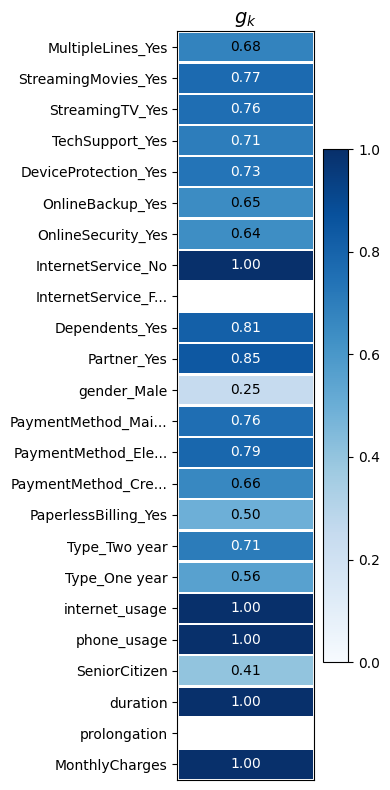

In [45]:
gk(features_train_up)

Попробуем исключить признаки: InternetService_No, MonthlyCharges, и phone_usage.

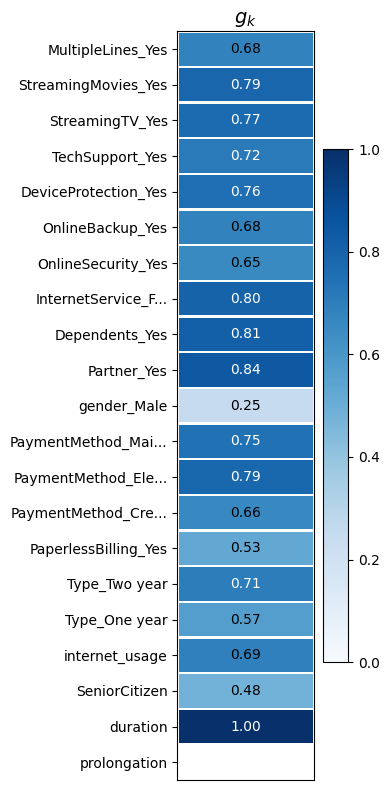

In [46]:
drop_list = ['InternetService_No', 'MonthlyCharges', 'phone_usage']
gk(features_train_up, drop_list)

График выглядит иначе - переобучим модель градиентного бустинга, исключив лишние признаки, и оценим метрики.

In [47]:
# переобучаем модель, исключив коррелирующие признаки
booster.fit(features_train_up.drop(drop_list, axis=1), target_train_up)
print('Модель обновлена.')

Модель обновлена.


In [48]:
print('Улучшение модели градиентного бустинга - оценка корреляции признаков.\n')
gk_AUC_ROC = booster.best_score_
gk_recall = booster.cv_results_['mean_test_recall'].max()
gk_precision = booster.cv_results_['mean_test_precision'].max()
print('Изменение метрики AUC_ROC:', (gk_AUC_ROC - results.loc[2,'validation_AUC-ROC']).round(3))
print('Изменение метрики recall:', (gk_recall  - results.loc[2,'validation_recall']).round(3))
print('Изменение метрики precision:', (gk_precision - results.loc[2,'validation_precision']).round(3))

Улучшение модели градиентного бустинга - оценка корреляции признаков.

Изменение метрики AUC_ROC: 0.007
Изменение метрики recall: 0.015
Изменение метрики precision: 0.009


После исключение коррелирующих признаков все метрики на валидационной выборке выросли. Продолжим настройку модели градиентного бустинга - оценим значимость оставщихся признаков. 

In [49]:
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_train_up.drop(drop_list, axis=1).columns).sort_values(ascending=False)
    plt.subplots(figsize=(8, 4))
    ax = sns.barplot(x=feature_imp, y=feature_imp.index, palette='Blues_r')
    _ = ax.set(xlabel='Оценка значимости признаков', ylabel='')
    _ = ax.set_title(str(model) + '\n')

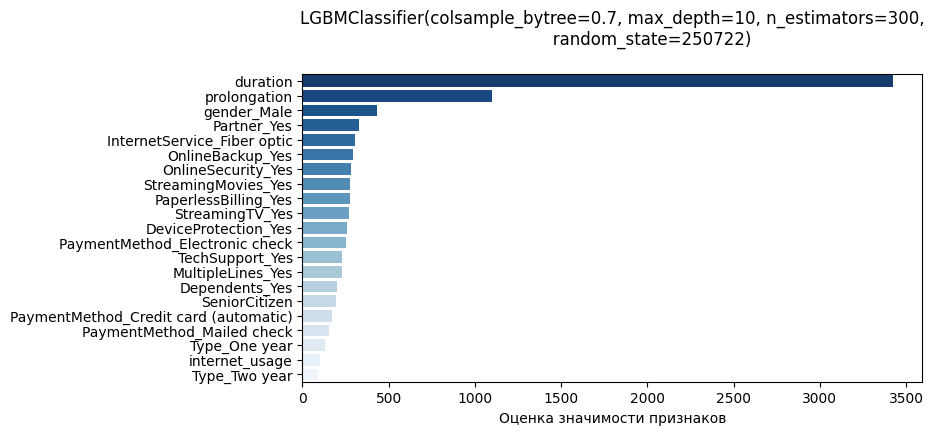

In [50]:
chart_feature_imp(booster.best_estimator_)

Наиболее значимы для модели синтетические признаки: prolongation, duration. 
Наименее значимы признаки: Type_One year, Type_two year - удалим их и пересчитаем метрику.

In [51]:
# обновим списко исключаемых признаков
drop_list.extend(['Type_One year', 'Type_Two year'])
# переобучаем модель, исключив малозначимые признаки
booster.fit(features_train_up.drop(drop_list, axis=1), target_train_up)
print('Модель обновлена.')

Модель обновлена.


In [52]:
print('Улучшение модели градиентного бустинга - оценка значимости признаков.\n')
print('Изменение метрики AUC_ROC:', (booster.best_score_ - gk_AUC_ROC).round(3))
print('Изменение метрики recall:', (booster.cv_results_['mean_test_recall'].max() - gk_recall).round(3))
print('Изменение метрики precision:', (booster.cv_results_['mean_test_precision'].max() - gk_precision).round(3))

Улучшение модели градиентного бустинга - оценка значимости признаков.

Изменение метрики AUC_ROC: 0.001
Изменение метрики recall: -0.001
Изменение метрики precision: 0.001


Похоже, что значения метрик градиентного бустинга на валидационной выборке достигли своего потолка. Переходим к тестированию.

***

[Вернуться к содержанию](#contents)

### Тестирование модели  <a name="subparagraph5.3"></a>
Протестируем улучшенную модель градиентного бустинга и построим матрицу ошибок.

In [53]:
predictions = booster.best_estimator_.predict(features_test.drop(drop_list, axis=1))
probabilities_test = booster.best_estimator_.predict_proba(features_test.drop(drop_list, axis=1))
probabilities_one_test = probabilities_test[:, 1]

print('Тестирование улучшенной модели градиентного бустинга')
print(f'Значение метрики AUC-ROC = {roc_auc_score(target_test, probabilities_one_test):.3f}')
print(f'Значение метрики recall = {recall_score(target_test, predictions):.3f}')
print(f'Значение метрики precision = {precision_score(target_test, predictions):.3f}')

Тестирование улучшенной модели градиентного бустинга
Значение метрики AUC-ROC = 0.934
Значение метрики recall = 0.789
Значение метрики precision = 0.775


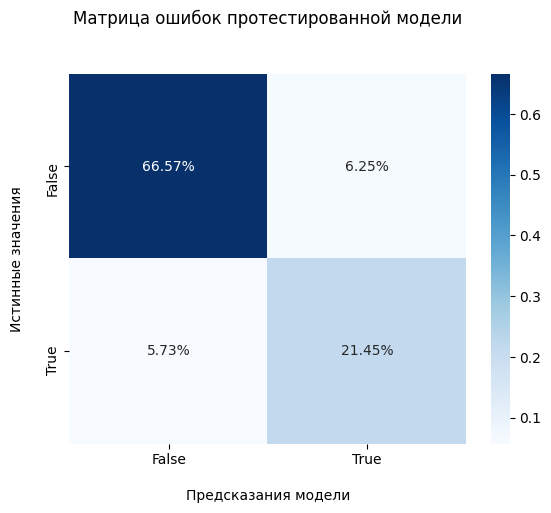

In [54]:
booster_matrix = confusion_matrix(target_test, predictions)
# изобразим матрицу ошибок модели градиентного бустинга в процентном представлении
ax = sns.heatmap(booster_matrix/np.sum(booster_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.set_title('Матрица ошибок протестированной модели\n\n');
ax.set_xlabel('\nПредсказания модели')
ax.set_ylabel('Истинные значения\n');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [55]:
false_negavite = (booster_matrix/np.sum(booster_matrix))[1,0]
print('Частота ошибок второго рода: {:.2%}'.format(false_negavite)) 

Частота ошибок второго рода: 5.73%


***

[Вернуться к содержанию](#contents)

## Общий вывод  <a name="paragraph6"></a>

Нам удалось простроить модель, прогнозирующую отток клиентов телеком-компании с метрикой качества AUC-ROC выше 0.92. Наиболее значимыми для модели являются синтетические признаки: стаж клиента (в днях) и количество пролонгаций договора.

Наша модель допускает "дорогостоящие" ошибки второго рода в ~6% случаев. Вероятность того, что модель заметит желание клиента расторнуть договор, при условии, что клиент действительно собирается это сделать, составляет 75,4%. Вероятность того, что клиент действительно расторгнет договор, при условии, что модель сделает такой прогноз, составляет 73,8%.

Чтобы оценить экономическую эффективность модели, предположим, что в среднем отток клиентов из компании составляет 1000 клиентов в год, а средняя выручка компании с каждого клиента составлят 1000 денег в год - в сумме 1 000 000 денег. Внедрив нашу модель с полнотой предсказаний 75%, компания сможет предотвратить отток 750 клиентов (750 000 денег). Оставшиеся 250 клиентов (250 000 денег) - это потери компании, которые модель не смогла предотвратить. Точность предсказаний 73% означает, что в 27% компания понесет расходы (промокоды, специальные условия и т.п.) на удержание заведомо лояльных клиентов.

Хорошо это или плохо?

По сигналу модели об уходящем клиенте компания совершает какие-либо действия. Например, предлагает клиентам специальные, более выгодные условия тарифа. Предположим, что одно такое спецпредложение - это уменьшение выручки компании на 100 денег в год. С учетом точности модели в 73% компании придется направить 750 / 0,73 = 1027 спецпредложений, недополучив при этом 102 700 денег прибыли. Итоговые годовые расходы телеком-компании составят: 250 000 + 102 700 = 352,7 тысяч денег. Но без внедрения модели компания потеряла бы один миллион. 

Следовательно выгода компании от внедрения и поддержки модели, предсказывающей отток клиентов, составлят 647,3 тысяч денег.

***

[Вернуться к содержанию](#contents)

# Отчет о результатах работы <a name="paragraph7"></a>

+ **Исследование прошло по плану**
    - [x] знакомство с данными и предобработка
        * календарные признаки с датой открытия и датой расторжения договора были приведены к типу `datetime` для того, чтобы на их основе, учитывая тип контракта (ежемесячный, на год или два) создать расчетные синтетиские признаки стажа клиента в днях и количества пролонгаций договора
        * из колонки с датой расторжения договора был сформирован целевой признак: закрыт договор (1) или нет (0)
        * были исключены бессодержательные записи о клиентах, заключивших договор с компанией в день выгрузки данных
        * было установлено, что большинство признаков бинарные, а значит целесообразно применить для них прямое кодирование - размерность матрицы признаков не будет чрезмерной
    - [x] исследовательский анализ
        * для того, чтобы узнать все ли клиенты уходят "потому, что дорого" исследованы среднемесячные расходы лояльных и ушедших клиентов
        * выдвинута и проверена гипотеза о том, что даже сомневающиеся клиенты не уходят, раньше истечения срока действия оплаченного периода или контракта (месяц, год или два года) 
        * взамен календарных признаков были введены синтетические - стаж клиента и количество пролонгаций доровора с момента регистрации, характеризующие уровень лояльности клиента
    - [x] построение модели
        * классы обучающей выборки были сбалансированны методом SMOTE
        * методом кросс-валидации обучены модели логистической регрессии, случайного леса и градиентного бустинга
        * лидирующая по результатам валидации модель LGBMClassifier была улучшена путем отбора признаков по уровню значимости и корреляции между собой
    - [x] оценка результатов работы
        * для оценка качества предсказаний модели использованы метрики Recall, Precision и AUC-ROC, а также оценка количества дорогостоящих ошибок второго рода
        * в общем выводе был оценен экономический эффект внедрения модели

 При знакомстве с данными мы выяснили, что 90% клиентов пользуются стационарной телефонной связью и только 78% пользуются интернетом. Проведя исследовательский анализ данных, мы установили, что сравнительно высокими расходами можно объяснить уход только части клиентов, остальные клиенты покинули компанию по менее очевидным причинам. Мы определили какие признаки в каком виде будут переданы в модель, подтвердив выдвинутую гипотезу с помощью теста на статистическую значимость. Решения, использованные при обучении и улучшении модели, позволили добиться требуемого качества предсказаний.
 

+ **Возникшие проблемых и их решение**
 
 Возникла сложность с оценкой корреляции / созависимости категориальных признаков. Выяснилось, что с помощью коэффициента инфляции дисперсии (variance inflation factor) можно оценивать мультиколлинеарность только количественных переменных. Удалось найти более универсальный инструмент, применимый к категориальным переменным, - $\phi_k$.  С его помощью получилось оценить глобальный коэффициент корреляции  между всеми признаками и провести их отбор.
 

+ **Ключевые шагах в решении задачи**
 
  - предобработка календарных переменными - формирование их них целевого и синтетических признаков duration и prolongation;
  - проверка гипотезы о клиентах лояльность которых не достоверна и фильтрация таких записей; 
  - балансировка обучающией выборки методом SMOTE для того, чтобы избежать переобучения;
  - улучшение лидирующей модели с помощью оценки корреляции и значимости признаков с последующим их отбором.
 

+ **Качество итоговой модели**

  К внедрению предгалается классификатор, работающий по алгоритму градиентного бустинга с метрикой качества AUC-ROC 0.92+. При стоимости удержания сомневающегося клиента в 10% от средней годовой выручки по одному клиенту, внедрение модели позволит снизить потери компании "Ниединогоразрыва.ком" на 65% в год.
  
  Наиболее значимыми для классификатора являются синтетиские признаки стажа клиента в днях и количества пролонгация договора, получаемые на из данных о дате заключения контракта и его типе. 
  К малозначительным признакам относятся: способ оплаты, пенсионный статус и тип контракта, данные о котором не нужны после расчета синтетических признаков.
  Признаки, сильно коррелирующие с остальными: информация об фактах подключения абонентов к интернету и телефонной линии и, внезапно, среднемесячные расходы клиентов.
  
  Статистику по малозначительным и скоррелированным признакам можно не вести, если это снизит расходы компании. Качество прогнозов модели от этого не ухудшится.
  
***

[Вернуться к содержанию](#contents)